## Motivation
I'm fairly new to both Pytorch and Text Classification (and for that matter, training Neural Networks). Goals:
1. Build an understanding and intuition around how RNNs work by implementing one using only `Linear` layers in Pytorch.
2. Get comfortable with a Pytorch workflow before tackling a more sophisticated architecture (ahem Transformers...).  Using static word embeddings is an easier starting point, even if they are being supplanted by dynamic embeddings.
3. Start contributing to Kaggle.

I found several sources helpful in implementing an RNN as a looped `Linear` layer. 

In particular my code for the rnn loop is based on this discussion:  
https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb  
Jeremy Howard, Sylvain Gugger  

But I didn't really understand the implementation until I looked at it from the matrix multiplication view, as in:   
https://gist.github.com/karpathy/587454dc0146a6ae21fc  
Andrej Karpathy

I also found these two notebooks by Kaggler Leigh useful for organizing Pytorch code:  
https://www.kaggle.com/leighplt/simple-recurrent-model-pytorch  
https://www.kaggle.com/leighplt/transformers-cv-train-inference-pytorch

If you see something, say something in the comments! And **if it's useful, please upvote**!

## Dependencies

In [ ]:
## Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import pickle

## Read data
train = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
train = train.rename(columns={'id':'ids'})
test = test.rename(columns={'id':'ids'})
with open('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', 'rb') as inglove:
    glove = pickle.load(inglove)

## Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Seed
torch.manual_seed(43)
torch.cuda.manual_seed(43)
np.random.seed(43)

## Hyperparameters

In [ ]:
## Hyperparameters
n_layers = 1
learning_rate = 1e-4
n_epochs = 6
tokenizer = get_tokenizer('spacy')
batch_size = 4                       # equivalent to n_observations
input_size = embedding_dim = 300     # also equivalent to n_features, vocab_size 
hidden_size = 50
max_len= train['excerpt'].apply(lambda x: len(tokenizer(x))).max()
seq_len = max_len   # with ^, the second dimension of an observation

## Transform










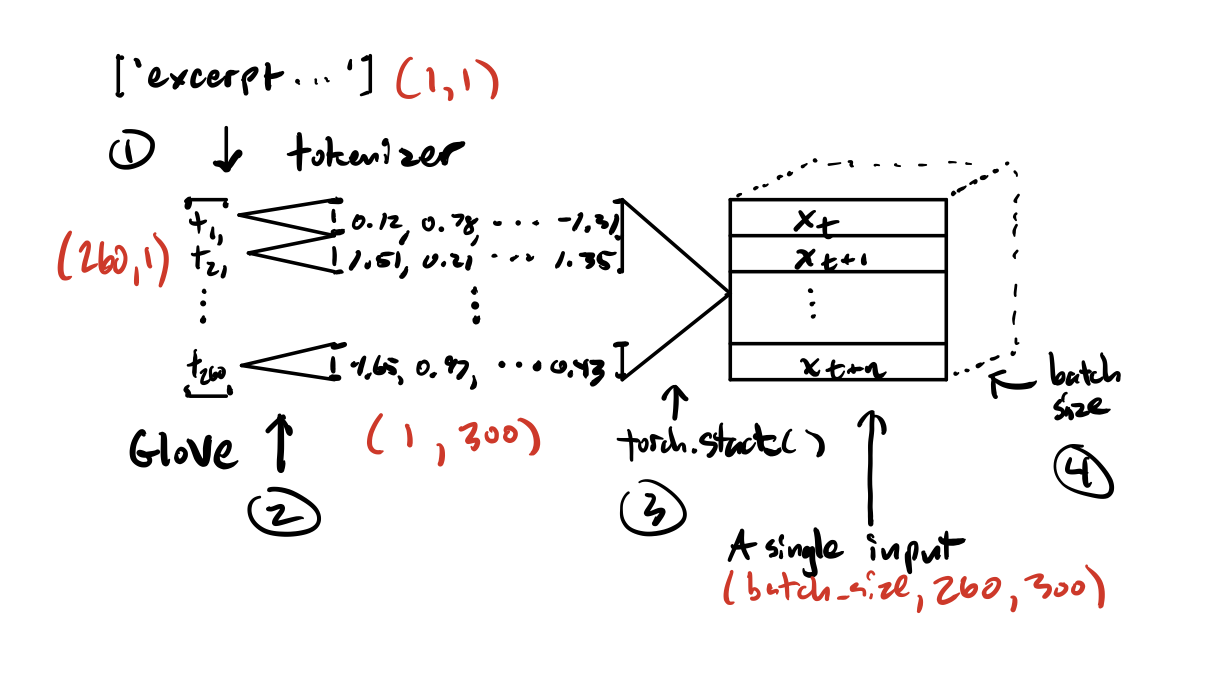









1. Each excerpt is first tokenized.
2. Then we look up the 300-d GloVe word-vector for each token
3. After substituting the appropriate word-vector for each token, the transformed excerpts are stacked into a 2-d `tensor` to be fed into the network.
4. The 2-d tensors are batched by a Dataloader

In [ ]:
def tokenize_and_vectorize(excerpt: str):
    tokenized = tokenizer(excerpt)
    vectorized_excerpt = []
    for token in tokenized:
        try:
            vectorized = torch.tensor(glove[token])
        except KeyError:
            vectorized = torch.zeros(embedding_dim)
        vectorized_excerpt.append(vectorized)
    return torch.stack(vectorized_excerpt)

train['inputs'] = train['excerpt'].apply(tokenize_and_vectorize)
test['inputs'] = test['excerpt'].apply(tokenize_and_vectorize)

## Batch and Load

In [ ]:
# Batch data
class CLDataset(Dataset):
    def __init__(self, df): 
        self.df = df

    def __len__(self):                   
        return self.df.shape[0]

    def __getitem__(self, idx):          
        column_map = {v:k for (k,v) in list(enumerate(train.columns))}
        X = self.df.iloc[idx, column_map['inputs']]
        y = self.df.iloc[idx, column_map['target']]
        return X, y

class CLTestDataset(Dataset):
    def __init__(self, df): 
        self.df = df

    def __len__(self):                   
        return self.df.shape[0]

    def __getitem__(self, idx):          
        column_map = {v:k for (k,v) in list(enumerate(test.columns))}
        X = self.df.iloc[idx, column_map['inputs']]
        y = torch.zeros((1))
        return X, y

def collate_fn(batch): 
    X, y = zip(*batch)
    X = pad_sequence(X, batch_first=True).to(device)
    y = torch.tensor(y).type(torch.float).to(device)
    return X, y

def collate_fn_test(batch):
    X, y = zip(*batch)
    X = pad_sequence(X, batch_first=True).to(device)
    y = torch.tensor(y).type(torch.float).to(device)
    return X, y


# Load data
train_set = CLDataset(train)
partition_lengths = [round(len(train_set)*.8), round(len(train_set)*.2)]
train_set, val_set = random_split(train_set, partition_lengths)

train_loader = DataLoader(dataset=train_set, 
                          batch_size=batch_size,
                          collate_fn=collate_fn,
                          shuffle=True)
                          
val_loader =  DataLoader(dataset=val_set, 
                         batch_size=batch_size,
                         collate_fn=collate_fn, 
                         shuffle=True)

test_set = CLTestDataset(test)
test_loader =  DataLoader(dataset=test_set, 
                          batch_size=1,
                          collate_fn=collate_fn_test,
                          shuffle=False)

## Rolling up a deep net

Each`forward` pass of `myRNN()` below has a loop that processes a sequence (actually a batch of them), one word at a time - so it is in effect a 200+ layer Neural Network w.r.t. to the individual words - one layer for each word. Typically each layer is represented as a *timestep* - see the right side of the image below. (Here, S_t represents the `hidden_state` passed forward in time, and X_t is an input word):


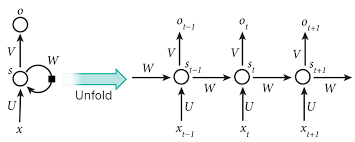  
https://www.kdnuggets.com/2015/10/recurrent-neural-networks-tutorial.html  

What makes it manageable is that we're reusing the same `Linear` (or `Dense`) layer over and over again - the weight tensor of that layer is only updated once per pass. From this perspective, it's really just a 1-hidden-layer Neural Network. This is the view seen on the left of the image.

There are two 'inputs' to think about:
1. The input to the forward pass is a single text document - one of our 'excerpts'. As mentioned in the Transform section above, **each of our input excerpts is represented as a 2-d tensor of shape (<=260, 300)** - The exact size of the sequence_length axis is variable between batches, but uniform within a batch (after padding).  

2. The input to the 'RNN layer' - the loop - is a single (1, 300) word vector sliced off of our 2-d input tensor - shown as **step 1** in this sketch:



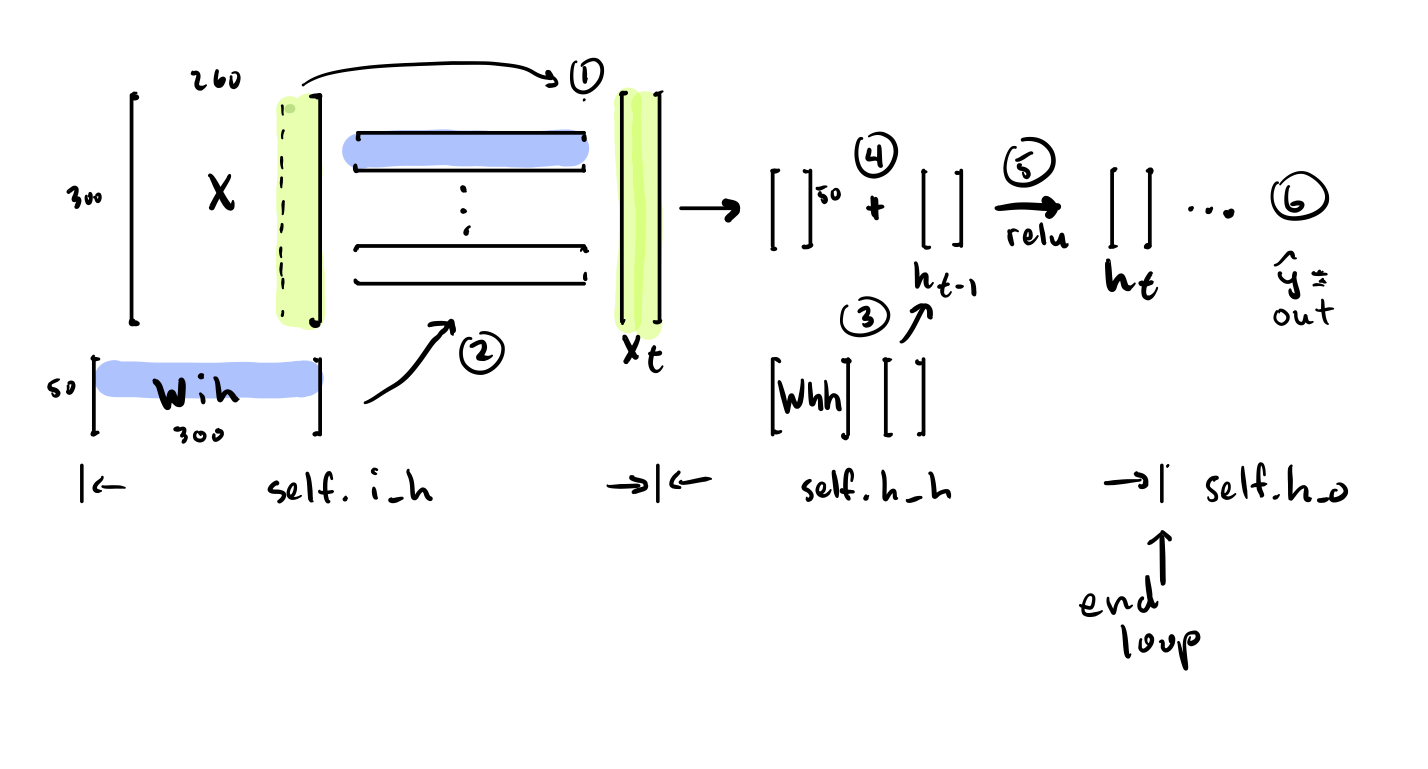
 

In **step 2** we perform the matrix multiplication W_ih @ X. From the view of an individual word vector x_t, that word vector is 'dotted' by each row of the W_ih weight matrix.

**Step 3** shows the previous hidden state being produced in the previous time step and then passed in to be added to the 50-dim transformed x_t in **step 4**.  

**Step 5** applies the activation function.

**Step 6** Note that we only use the output y_hat for the final iteration of the loop, after all of the time steps are completed (indicated by the ellipsis ...) . This is our (1, 1) float, which we use to calculate the loss. This makes our network a *sequence-to-vector* RNN. Other scenarios might use the outputs y_t from each iteration of the loop - these would be *sequence-to-sequence* RNNs.
   
  
**In summary, to 'Roll our own' RNN we just:**
1. lay out linear layers, one for each token in our sequence
2. 'roll up' the layers by looping over that single layer. 

In [ ]:
## Create network
class myRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Linear(input_size,  hidden_size)
        self.h_h = nn.Linear(hidden_size, hidden_size)
        self.h_o = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # initialize hidden_state 
        self.h   = torch.zeros((1,hidden_size)).to(device)
        time_steps = x.shape[1]     
        for t in range(time_steps): 
            word_vector = x[:, t, :]  # x_t
            # prev hidden_state + input word
            self.h = self.h + self.i_h(word_vector)
            # multiply by hidden weights, activate
            self.h = F.relu(self.h_h(self.h)) 
        
        out = self.h_o(self.h).squeeze(dim=1) 
        self.h = self.h.detach()
    
        return out

## Training  
- We're using static word embeddings pretrained on a huge corpus
- Our training data is tiny by comparison 
- So we *definitely* want to **freeze the weights** on our input_to_hidden layer.  

There are several ways to freeze a layer in pytorch. The two step process below is common.
1. Set `requires_grad_` to `False` for the input layer.
2. Tell our optimizer to ignore any layers configured as such.

In [ ]:
## Initialize network
model = myRNN().to(device)

## Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    [param for param in model.parameters() if param.requires_grad == True],
    lr=learning_rate)
## Train network
for epoch in range(n_epochs):
    
    # Training
    train_loss = 0.0
    model.train()
    model.i_h.requires_grad_ = False
    for batch_idx, (inputs, labels) in enumerate(train_loader):       
        outputs = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    for batch_idx, (inputs, labels) in enumerate(val_loader):
       
        outputs = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels) 
        val_loss += loss.item()

    print(f"Epoch:      {epoch}   "                         \
          f"Train Loss: {train_loss/len(train_loader)}    "  \
          f"Valid Loss: {val_loss/len(val_loader)}" )

## Inference

In [ ]:
preds = [] 
with torch.no_grad():
    for _, (inputs, _) in enumerate(test_loader):
        outputs = model(inputs)
        preds.append(outputs.squeeze(-1).cpu().numpy())

submission = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')
submission['target'] = preds
submission.to_csv("submission.csv",index = False)